In [11]:
# v-ből indulva k lépésben elérhető maximum
def opt_flow(G, v, k):
    if k == 1:
        return 0
    
    else:
        if (v, v) in G.edges():
            val_1 = G.edges[v, v]['flow']
            G.remove_edge(v, v)
            val_1 = val_1 * (k-1) + opt_flow(G, v, k-1)
            
        else:
            val_1 = 0
            
        val_2 = [opt_flow(G, u, k-G.edges[v, u]['weight']) for u in G.neighbors(v) if k-G.edges[v, u]['weight'] >= 1] + [0]
        
        return max(max(val_2), val_1)

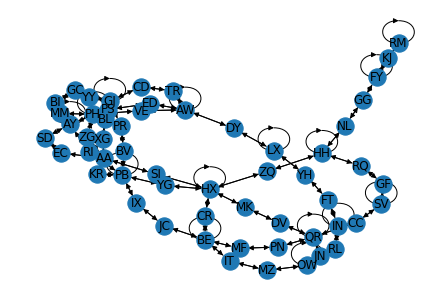

In [12]:
#31. feladat:

import networkx as nx

with open('16_nap.txt', 'r') as f:
    lines = f.read().split('\n')
    G = nx.DiGraph()
    
    for line in lines:
        line = line.split(' ')
        
        node = line[1]
        fl = int(line[line.index('flow') + 1].split('=')[1].split(';')[0])
        if fl != 0:
            G.add_edge(node, node, flow = fl)

        if 'valves' in line:
            line = line[line.index('valves') + 1:]
            line = [item.strip(',') for item in line]
            #print(line)
            
        else:
            line = line[line.index('valve') + 1:]
            #print(line)
            
        G.add_edges_from([(node, item) for item in line])
        
#G.edges['ED', 'ED']
nx.draw(G, with_labels = True)
#print(opt_flow(G, 'AA', 30))



In [31]:
H = nx.Graph()
H.add_nodes_from([v for v in G.nodes() if (v,v) in G.edges])
H.add_node('ED')

for v in H.nodes():
    for u in H.nodes():
        if u != v:
            H.add_weighted_edges_from([(u, v, nx.shortest_path_length(G, u, v))])
        elif u != 'ED':
            H.add_edge(u, v, flow = G.edges[u, u]['flow'])
        else:
            H.add_edge('ED', 'ED', flow = 0)
            
#nx.draw(H, with_labels = True)

#for e in H.edges.items():
    #print(e)
    
print(opt_flow(H, 'ED', 30))

KeyboardInterrupt: 

In [32]:
import numpy as np
import re
from itertools import combinations, permutations
from copy import copy

from dataclasses import dataclass

@dataclass
class Cave():
    label: str
    tunnels: tuple[str]
    flow: int
        
def load_data(filename):
    with open(filename, 'r') as f:
        lines = map(str.strip, f.readlines())
    caves = []
    for l in lines:
        labels = re.findall('[A-Z]{2}', l)
        flow = int(re.search('\d+', l)[0])
        caves.append(Cave(labels[0], labels[1:], flow))
    return caves

def adjacency_matrix(nodes: list[Cave]) -> np.ndarray:
    index_mapping = {n.label: i for i, n in enumerate(nodes)}
    A = np.zeros((len(nodes), len(nodes)), dtype=int)
    for n in nodes:
        for t in n.tunnels:
            A[index_mapping[n.label], index_mapping[t]] = 1
    return A

def distance_matrix(A: np.ndarray) -> np.ndarray:
    """Uses the Floyd-Warshall algorithm to compute a distance
       matrix from an adjacency matrix.
       
       
        Args:
        A (np.ndarray): Adjacency matrix.
        
    Returns:
        np.ndarray
        
    """
    l = A.shape[0]
    D = np.where(A, A, 10000)
    d = np.diag([1]*l, 0)
    D = np.where(d, 0, D)
    for i, row in enumerate(D):
        neighbours = np.where(row != 10000)[0]
        for n1, n2 in permutations(neighbours, 2):
            d = min(row[n1] + row[n2], D[n1, n2])
            D[n1, n2] = d
            D[n2, n1] = d
    return D.astype(int)

class Path():
    
    def __init__(self,
                 time: int,
                 initial_cave: int) -> None:
        self.time = time
        self.visited=[initial_cave]
        self.pressure = 0
        
    def copy(self):
        new_path = Path(time=self.time,
                        initial_cave=self.visited[0])
        new_path.visited = self.visited.copy()
        new_path.pressure = self.pressure
        return new_path
    
    
def complete_paths(caves, total_time, stopping=False):
    A = adjacency_matrix(caves)
    D = distance_matrix(A)
    labels = [c.label for c in caves]
    flows = np.array([c.flow for c in caves])
    initial_cave = next(i for i, c in enumerate(caves) if c.label == 'AA')

    path = Path(total_time, initial_cave)
    stack = [path]
    complete_paths = []
    while stack:
        path = stack.pop(0)
        if stopping: complete_paths.append(path)
        new = []
        possible_next_caves = [i for i, f in enumerate(flows) if (i not in path.visited) and (f != 0)]
        times_per_cave = [D[path.visited[-1]][c]+1 for c in possible_next_caves]
        for t, c in zip(times_per_cave, possible_next_caves):
            if path.time - t <= 0:
                continue
            extended_path = path.copy()
            extended_path.time -= t
            extended_path.visited.append(c)
            extended_path.pressure += (path.time - t) * flows[c]
            new.append(extended_path)
        if new:
            stack.extend(new)
        else:
            if not stopping:
                complete_paths.append(path)
    return complete_paths


def max_pressure_dual_paths(paths):
    ranked_paths = sorted(paths, key=lambda x: x.pressure, reverse=True)
    max_p = 0
    j = 0
    for i, a in enumerate(ranked_paths):
        if i > j: continue
        x = set(tuple(a.visited[1:]))
        for j, b in enumerate(ranked_paths[i+1:], i):
            if a.pressure + b.pressure <= max_p:
                break
            y = set(tuple(b.visited[1:]))
            if len(set.intersection(x, y)) == 0:
                if a.pressure + b.pressure > max_p:
                    max_p = a.pressure + b.pressure
    return max_p

def solve_part_1(filename):
    caves = load_data(filename)
    paths = complete_paths(caves, 30)
    return max([p.pressure for p in paths])

def solve_part_2(filename):
    caves = load_data(filename)
    paths = complete_paths(caves, 26, stopping=True)
    return max_pressure_dual_paths(paths)

filename = '16_nap.txt'
solve_part_1(filename)

2359

In [33]:
filename = '16_nap.txt'
solve_part_2(filename)

2999